In [1]:
import math
import collections
import cv2
from IPython.display import clear_output

import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.spatial.transform import Rotation as R

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# 1. Object Detection

In [34]:
# 0.1. 클라이언트 생성  
client = RemoteAPIClient()
# 0.2. 시뮬레이션 객체 가져오기
sim = client.require("sim")

In [35]:
joints = []
# 5개의 관절 가져오기
for i in range(5):
    joints.append(sim.getObject(f"/youBotArmJoint{i}"))

# Gripper Joint
joints.append(sim.getObject(f"/youBotGripperJoint2"))

# camera
camera_1 = sim.getObject(f"/camera_1")

for joint in joints:
    sim.setObjectInt32Param(
        joint,
        sim.jointintparam_dynctrlmode,
        sim.jointdynctrl_position,
    )

In [36]:
def read_camera_1():
    result = sim.getVisionSensorImg(camera_1)
    img = np.frombuffer(result[0], dtype=np.uint8)
    img = img.reshape((result[1][1], result[1][0], 3))
    img = cv2.flip(img, 1)
    return img

In [37]:
def detect_red_box(img):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # BGR에서 HSV로 변환
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # 빨간색의 HSV 범위 설정
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])
    # 빨간색 마스크 생성
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    red_mask = mask1 + mask2
    # 마스크를 이용해 원본 이미지에서 빨간색 부분 추출
    red_image = cv2.bitwise_and(image, image, mask=red_mask)
    # 컨투어 찾기
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 원본 이미지에 컨투어(상자) 그리기
    bboxs = []
    for contour in contours:
        # 경계 상자 그리기
        x, y, w, h = cv2.boundingRect(contour)
        bboxs.append((x, y, w, h))
    return bboxs

In [38]:
import time

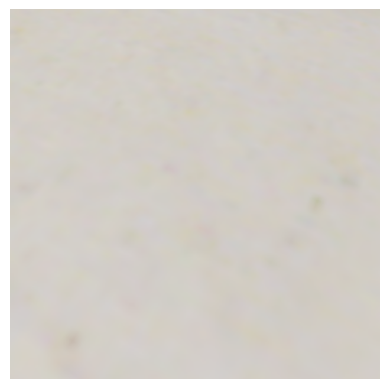

In [40]:
n_steps = 100

# start simulation
sim.setStepping(True)
sim.startSimulation()
for i in range(n_steps):
    if i == 1:
        time.sleep(5)
    sim.setJointTargetPosition(joints[0], i * 0.005)
    img = read_camera_1()
    bboxs = detect_red_box(img)
    clear_output(wait=True)
    plt.imshow(img)
    for  x, y, w, h in bboxs:
        rect = patches.Rectangle((x, y), w, h, linewidth=1,
                                               edgecolor='g',
                                               facecolor='none')
        plt.gca().add_patch(rect)
    plt.axis('off')
    plt.show()
    sim.step()

sim.stopSimulation()

# 2. Camera Location & Orientation

In [2]:
# 0.1. 클라이언트 생성  
client = RemoteAPIClient()
# 0.2. 시뮬레이션 객체 가져오기
sim = client.require("sim")
# pi / 2
PI_HALF = np.pi / 2

In [3]:
joints = []
# 5개의 관절 가져오기
for i in range(5):
    joints.append(sim.getObject(f"/youBotArmJoint{i}"))

# Gripper Joint
joints.append(sim.getObject(f"/youBotGripperJoint2"))

points = []
# Car 위치
points.append(sim.getObject(f"/youBot_ref"))
# 5개의 관절 위치 가져오기
for i in range(5):
    points.append(sim.getObject(f"/p{i}_ref"))
# End Effector 위치
points.append(sim.getObject(f"/pe_ref"))

# camera
camera_1 = sim.getObject(f"/camera_1")

for joint in joints:
    sim.setObjectInt32Param(
        joint,
        sim.jointintparam_dynctrlmode,
        sim.jointdynctrl_position,
    )

In [4]:
# joint angle 조회
def read_joints(joints):
    js = []
    for joint in joints:
        j = sim.getJointPosition(joint)
        js.append(j)
    return js

In [5]:
# point position & orientation 조회
def read_points(points):
    ps = []
    for point in points:
        p = sim.getObjectPosition(point)
        o = sim.getObjectQuaternion(point)
        ps.append(np.array(p + o))
    return ps

In [12]:
# camera_1 position & orientation 조회
def read_camera_1():
    p = sim.getObjectPosition(camera_1)
    o = sim.getObjectQuaternion(camera_1)
    return np.array(p + o)

In [13]:
# joint 제어
def control_joint(joints, thetas):
    for joint, j in zip(joints, thetas):
        sim.setJointTargetPosition(joint, j)

In [31]:
# forward kinematics
def fk(thetas, params):
    j1, j2, j3, j4 = thetas[:4]
    j0, pc = params[:2]
    # 월드 기준 자동차
    dc = R.from_quat(pc[3:]).as_euler('xyz')[-1]
    TWC = np.array([
        [np.cos(dc), -np.sin(dc), 0, pc[0]],
        [np.sin(dc),  np.cos(dc), 0, pc[1]],
        [         0,           0, 1, pc[2]],
        [         0,           0, 0,     1]
    ])

    # 자동차 -> joint-0
    TC0 = np.array([ # 좌표이동 및 y축을 기준으로 90도 회전
        [1, 0, 0, 0.0],
        [0, 1, 0, 0.166],
        [0, 0, 1, 0.099],
        [0, 0, 0, 1]
    ]) @ np.array([
        [np.cos(j0), -np.sin(j0), 0, 0],
        [np.sin(j0),  np.cos(j0), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])

    # joint-0 -> joint-1
    ay1 = PI_HALF
    T01 = np.array([ # 좌표이동 및 y축을 기준으로 90도 회전
        [ np.cos(ay1), 0, np.sin(ay1), 0.0],
        [           0, 1,           0, 0.033],
        [-np.sin(ay1), 0, np.cos(ay1), 0.147],
        [           0, 0,           0, 1]
    ]) @ np.array([ # z축을 기준으로 j1만큼 회전
        [np.cos(j1), -np.sin(j1), 0, 0],
        [np.sin(j1),  np.cos(j1), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TC1 = TC0 @ T01

    # joint-1 -> joint-2
    T12 = np.array([ # 좌표이동, 회전 없음
        [1, 0, 0, -0.155],
        [0, 1, 0,  0.0],
        [0, 0, 1,  0.0],
        [0, 0, 0,  1]
    ]) @ np.array([ # z축을 기준으로 j2만큼 회전
        [np.cos(j2), -np.sin(j2), 0, 0],
        [np.sin(j2),  np.cos(j2), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TC2 = TC1 @ T12

    # joint-2 -> joint-3
    T23 = np.array([ # 좌표이동, 회전 없음
        [1, 0, 0, -0.135],
        [0, 1, 0,  0.0],
        [0, 0, 1,  0.0],
        [0, 0, 0,  1]
    ]) @ np.array([ # z축을 기준으로 j3만큼 회전
        [np.cos(j3), -np.sin(j3), 0, 0],
        [np.sin(j3),  np.cos(j3), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TC3 = TC2 @ T23

    # joint-3 -> joint-4
    ay4 = -PI_HALF
    T34 = np.array([ # 좌표이동 및 y축을 기준으로 -90도 회전
        [ np.cos(ay4), 0, np.sin(ay4), -0.081],
        [           0, 1,           0,  0.0],
        [-np.sin(ay4), 0, np.cos(ay4),  0.0],
        [           0,  0,          0,  1]
    ]) @ np.array([ # z축을 기준으로 j4만큼 회전
        [np.cos(j4), -np.sin(j4), 0, 0],
        [np.sin(j4),  np.cos(j4), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TC4 = TC3 @ T34
    TW4 = TWC @ TC4

    pe_hat = TW4 @ np.array([ 0.0,   0.0,   0.123, 1])
    pc_hat = TW4 @ np.array([ 0.0,   0.0,   0.070, 1])
    oc_hat = R.from_matrix(TW4[:-1, :-1]).as_quat()

    return pe_hat[:3], np.concatenate((pc_hat[:3], oc_hat))

[-2.62  0.   -0.  ] [-2.62  0.    0.  ]
[-2.62  0.   -0.  ] [-2.62  0.   -0.  ]
[-2.62  0.   -0.  ] [-2.62  0.   -0.  ]
[-2.62  0.    0.  ] [-2.62  0.    0.  ]
[-2.62  0.    0.  ] [-2.62  0.    0.  ]
[-2.62  0.    0.01] [-2.62  0.    0.01]
[-2.62  0.    0.01] [-2.62  0.    0.01]
[-2.62  0.    0.01] [-2.62  0.    0.01]
[-2.62  0.    0.02] [-2.62  0.    0.02]
[-2.62  0.    0.02] [-2.62  0.    0.02]
[-2.62  0.    0.02] [-2.62  0.    0.02]
[-2.62  0.    0.03] [-2.62  0.    0.03]
[-2.62  0.    0.03] [-2.62  0.    0.03]
[-2.62  0.    0.03] [-2.62  0.    0.03]
[-2.62  0.    0.04] [-2.62  0.    0.04]
[-2.62  0.    0.04] [-2.62  0.    0.04]
[-2.62  0.    0.04] [-2.62  0.    0.04]
[-2.62  0.    0.05] [-2.62  0.    0.05]
[-2.62  0.    0.05] [-2.62  0.    0.05]
[-2.62  0.    0.05] [-2.62  0.    0.05]
[-2.62  0.    0.06] [-2.62  0.    0.06]
[-2.62  0.    0.06] [-2.62  0.    0.06]
[-2.62  0.    0.06] [-2.62  0.    0.06]
[-2.62  0.    0.07] [-2.62  0.    0.07]
[-2.62  0.    0.07] [-2.62  0.    0.07]


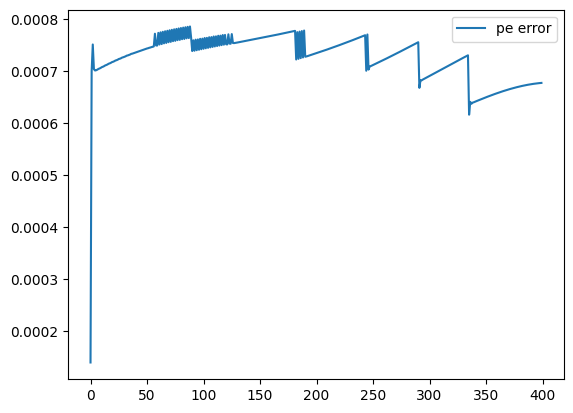

In [33]:
n_steps = 400
log = np.zeros((n_steps, 1))

# 시뮬레이션 실행
sim.setStepping(True)
sim.startSimulation()

# 각 스텝 실행
for i in range(n_steps):
    js = read_joints(joints)
    ps = read_points(points)
    pc = read_camera_1()
    oe = ps[6][3:]
    pe_hat, pc_hat = fk(js[1:], [js[0], ps[0]])
    diff = R.from_quat(pc[3:]).as_matrix() - R.from_quat(pc_hat[3:]).as_matrix()
    log[i][0] = np.linalg.norm(diff)

    print(np.round(R.from_quat(pc[3:]).as_euler('xyz'), 2), np.round(R.from_quat(pc_hat[3:]).as_euler('xyz'), 2))

    # control joint
    for i in range(len(js) - 1):
        if i == 0:
            js[i] += 0.005
        elif i == 1:
            js[i] = - np.pi / 6
        elif i == 2 or i == 3:
            js[i] = -np.pi / 3
        elif i == 4:
            js[i] = 0.01
        else:
            js[i] == 0
    control_joint(joints, js)
    sim.step()

# 시뮬레이션 종료
sim.stopSimulation()

# 로그 시각화
plt.plot(log[:, 0], label="pe error")
plt.legend()
plt.show()

# 3. Target Location & Orientation

In [83]:
# 0.1. 클라이언트 생성  
client = RemoteAPIClient()
# 0.2. 시뮬레이션 객체 가져오기
sim = client.require("sim")
# pi / 2
PI_HALF = np.pi / 2

In [84]:
joints = []
# 5개의 관절 가져오기
for i in range(5):
    joints.append(sim.getObject(f"/youBotArmJoint{i}"))

# Gripper Joint
joints.append(sim.getObject(f"/youBotGripperJoint2"))

points = []
# Car 위치
points.append(sim.getObject(f"/youBot_ref"))
# camera 위치
points.append(sim.getObject(f"/camera_1"))
# Target 위치
points.append(sim.getObject(f"/Target"))

# camera
camera_1 = sim.getObject(f"/camera_1")

for joint in joints:
    sim.setObjectInt32Param(
        joint,
        sim.jointintparam_dynctrlmode,
        sim.jointdynctrl_position,
    )

In [85]:
# joint angle 조회
def read_joints(joints):
    js = []
    for joint in joints:
        j = sim.getJointPosition(joint)
        js.append(j)
    return js

In [86]:
# point position & orientation 조회
def read_points(points):
    ps = []
    for point in points:
        p = sim.getObjectPosition(point)
        o = sim.getObjectQuaternion(point)
        ps.append(np.array(p + o))
    return ps

In [87]:
# camera image 조회
def read_camera_1():
    result = sim.getVisionSensorImg(camera_1)
    img = np.frombuffer(result[0], dtype=np.uint8)
    img = img.reshape((result[1][1], result[1][0], 3))
    img = cv2.flip(img, 1)
    return img

In [88]:
def detect_red_box(img):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # BGR에서 HSV로 변환
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # 빨간색의 HSV 범위 설정
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])
    # 빨간색 마스크 생성
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    red_mask = mask1 + mask2
    # 마스크를 이용해 원본 이미지에서 빨간색 부분 추출
    # red_image = cv2.bitwise_and(image, image, mask=red_mask)
    # 컨투어 찾기
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 원본 이미지에 컨투어(상자) 그리기
    bboxs = []
    for contour in contours:
        # 경계 상자 그리기
        x, y, w, h = cv2.boundingRect(contour)
        bboxs.append((x, y, w, h))
    return bboxs

In [89]:
# joint 제어
def control_joint(joints, thetas):
    for joint, j in zip(joints, thetas):
        sim.setJointTargetPosition(joint, j)

In [90]:
# forward kinematics
def fk(thetas, params):
    j1, j2, j3, j4 = thetas[:4]
    j0 = params[0]

    # 자동차 -> joint-0
    TC0 = np.array([ # 좌표이동 및 y축을 기준으로 90도 회전
        [1, 0, 0, 0.0],
        [0, 1, 0, 0.166],
        [0, 0, 1, 0.099],
        [0, 0, 0, 1]
    ]) @ np.array([
        [np.cos(j0), -np.sin(j0), 0, 0],
        [np.sin(j0),  np.cos(j0), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])

    # joint-0 -> joint-1
    ay1 = PI_HALF
    T01 = np.array([ # 좌표이동 및 y축을 기준으로 90도 회전
        [ np.cos(ay1), 0, np.sin(ay1), 0.0],
        [           0, 1,           0, 0.033],
        [-np.sin(ay1), 0, np.cos(ay1), 0.147],
        [           0, 0,           0, 1]
    ]) @ np.array([ # z축을 기준으로 j1만큼 회전
        [np.cos(j1), -np.sin(j1), 0, 0],
        [np.sin(j1),  np.cos(j1), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TC1 = TC0 @ T01

    # joint-1 -> joint-2
    T12 = np.array([ # 좌표이동, 회전 없음
        [1, 0, 0, -0.155],
        [0, 1, 0,  0.0],
        [0, 0, 1,  0.0],
        [0, 0, 0,  1]
    ]) @ np.array([ # z축을 기준으로 j2만큼 회전
        [np.cos(j2), -np.sin(j2), 0, 0],
        [np.sin(j2),  np.cos(j2), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TC2 = TC1 @ T12

    # joint-2 -> joint-3
    T23 = np.array([ # 좌표이동, 회전 없음
        [1, 0, 0, -0.135],
        [0, 1, 0,  0.0],
        [0, 0, 1,  0.0],
        [0, 0, 0,  1]
    ]) @ np.array([ # z축을 기준으로 j3만큼 회전
        [np.cos(j3), -np.sin(j3), 0, 0],
        [np.sin(j3),  np.cos(j3), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TC3 = TC2 @ T23

    # joint-3 -> joint-4
    ay4 = -PI_HALF
    T34 = np.array([ # 좌표이동 및 y축을 기준으로 -90도 회전
        [ np.cos(ay4), 0, np.sin(ay4), -0.081],
        [           0, 1,           0,  0.0],
        [-np.sin(ay4), 0, np.cos(ay4),  0.0],
        [           0,  0,          0,  1]
    ]) @ np.array([ # z축을 기준으로 j4만큼 회전
        [np.cos(j4), -np.sin(j4), 0, 0],
        [np.sin(j4),  np.cos(j4), 0, 0],
        [         0,           0, 1, 0],
        [         0,           0, 0, 1]
    ])
    TC4 = TC3 @ T34

    pe_hat = TC4 @ np.array([ 0.0,   0.0,   0.123, 1])
    pc_hat = TC4 @ np.array([ 0.0,   0.0,   0.075, 1])
    oc_hat = R.from_matrix(TC4[:-1, :-1]).as_quat()

    return pe_hat[:3], np.concatenate((pc_hat[:3], oc_hat))

In [91]:
def find_min_index(base_x, zero_y, bboxs):
    min_zero_d = 0xFFFF
    min_index = -1
    for  i, (x, y, w, h) in enumerate(bboxs):
        center_x = x + w // 2
        center_y = y + h // 2
        zero_d = (base_x - center_x)**2 + (zero_y - center_y)**2
        if zero_d < min_zero_d:
            min_zero_d = zero_d
            min_index = i
    return min_index

In [92]:
def draw_bboxs(min_index, bboxs):
    for  i, (x, y, w, h) in enumerate(bboxs):
        rect = patches.Rectangle((x, y), w, h, linewidth=1,
                                  edgecolor='g' if i == min_index else 'k',
                                  facecolor='none')
        plt.gca().add_patch(rect)

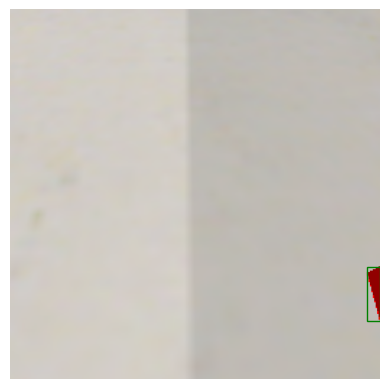

In [ ]:
n_steps = 400

# 시뮬레이션 실행
sim.setStepping(True)
sim.startSimulation()

# 각 스텝 실행
for i in range(n_steps):
    # fk
    js = read_joints(joints)
    ps = read_points(points)
    pe_hat, pc_hat = fk(js[1:], [js[0]])

    # camera read
    img = read_camera_1()
    base_x = img.shape[1] // 2
    base_y = img.shape[0] // 2
    zero_y = img.shape[0]
    # target detect
    bboxs = detect_red_box(img)
    min_index = find_min_index(base_x, zero_y, bboxs)
    # draw image
    clear_output(wait=True)
    plt.imshow(img)
    draw_bboxs(min_index, bboxs)
    plt.axis('off')
    plt.show()
    # move to target
    if min_index >= 0:
        x, y, w, h = bboxs[min_index]
        center_x = x + w // 2
        center_y = y + h // 2
        diff_x = center_x - base_x
        diff_y = center_y - base_y
        if abs(diff_x) > 5 or abs(diff_y) > 5:
            js[0] -= np.clip(diff_x / 10, -0.005, 0.005)
            js[1] -= np.clip(diff_y / 10, -0.005, 0.005)
            control_joint(joints, js)
        else:
            xyz = R.from_quat(pc_hat[3:]).as_euler('xyz')
            theta_z = np.pi + xyz[0]
            theta_x = xyz[2]
            dist = pc_hat[2] * np.tan(theta_z)
            loc_hat = pc_hat[:3] + dist * np.array([-np.sin(theta_x), np.cos(theta_x), 0])
            loc = ps[-1][:3] - ps[0][:3]
            print(loc, loc_hat)

    sim.step()

# 시뮬레이션 종료
sim.stopSimulation()

In [76]:
0.123 - 0.73949 + 0.69103

0.07454000000000005